# **TT2 - Modelo GARCH-B1**

In [1]:
!pip -q install "numpy>=2.0" "scipy>=1.11" "pandas>=2.0" "arch>=7.0"

import IPython, time; time.sleep(0.5)
IPython.Application.instance().kernel.do_shutdown(True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 12.5 MB/s eta 0:00:00


{'status': 'ok', 'restart': True}

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

df = pd.read_csv('/content/train_data (1).csv')

assert 'date' in df.columns, "No 'date'."
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

num_cols = [c for c in df.columns if c != 'date' and np.issubdtype(df[c].dtype, np.number)]
print("Rango de fechas:", df['date'].min().date(), "→", df['date'].max().date(), "| N=", len(df))
print("Numéricas detectadas:", num_cols)
df.head()

Rango de fechas: 2020-01-03 → 2024-04-04 | N= 1038
Numéricas detectadas: ['open_d0', 'high_d0', 'volume_d0', 'sp500_d0', 'wti_oil_d0', 'vix_d0', 'udis_d1', 'cetes_28_d1', 'log_ret']


,date,open_d0,high_d0,volume_d0,sp500_d0,wti_oil_d0,vix_d0,udis_d1,cetes_28_d1,log_ret
0,2020-01-03,1.331187,0.492034,-0.635406,-0.538411,0.799674,-0.990817,-0.114598,0.287126,0.004213
1,2020-01-06,0.268856,-0.428074,-0.758357,0.220907,0.070369,-1.011229,1.165722,0.840927,-0.002907
2,2020-01-07,0.045048,0.011808,-0.382451,-0.232329,-0.272940,-1.018433,-0.114598,0.323933,-0.007614
3,2020-01-08,-0.817603,-0.196681,-0.329850,0.318457,-1.409398,-1.059256,-0.114141,0.272177,0.007065
4,2020-01-09,0.614515,0.220832,-0.112830,0.443154,-0.048030,-1.168519,-0.114141,-1.678324,0.002274


- Tomo la columna log_ret, que representa los rendimientos logarítmicos diarios del IPC, y le aplico un modelo GARCH(1,1).
La idea es que este modelo ayude a estimar y predecir la volatilidad condicional de la serie, es decir, cómo varía la “intensidad” de los cambios a lo largo del tiempo. Antes de ajustar el modelo, centro la serie para mejorar la interpretación de los residuos, aunque el modelo igual incluye un término de media.

In [18]:
from arch import arch_model

assert 'log_ret' in df.columns, "No encuentro 'log_ret' en el CSV."
y = pd.to_numeric(df['log_ret'], errors='coerce').dropna()

y_centered = y - y.mean()

# GARCH(1,1)
am = arch_model(y_centered, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3261.02
Distribution:                  Normal   AIC:                          -6514.03
Method:            Maximum Likelihood   BIC:                          -6494.25
                                        No. Observations:                 1038
Date:                Thu, Nov 06 2025   Df Residuals:                     1037
Time:                        21:11:51   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.2513e-05  8.714e-06      2.583  9.782e-03 [5.

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


- aquí analizo algunos indicadores clave , alpha + beta, que me dice qué tan persistente es la volatilidad en el tiempo. Si la suma está cerca de 1, significa que los periodos de alta volatilidad tienden a durar más.

Semuestran tres graficas:

1. La serie de rendimientos (para ver los movimientos originales).

2. La volatilidad condicional estimada (desviación estándar GARCH).

3. Los residuos estandarizados (para revisar si quedaron más estables tras modelar la varianza).

Omega: 0.000003 | Alpha: 0.050000 | Beta: 0.930000 | Alpha+Beta: 0.980000


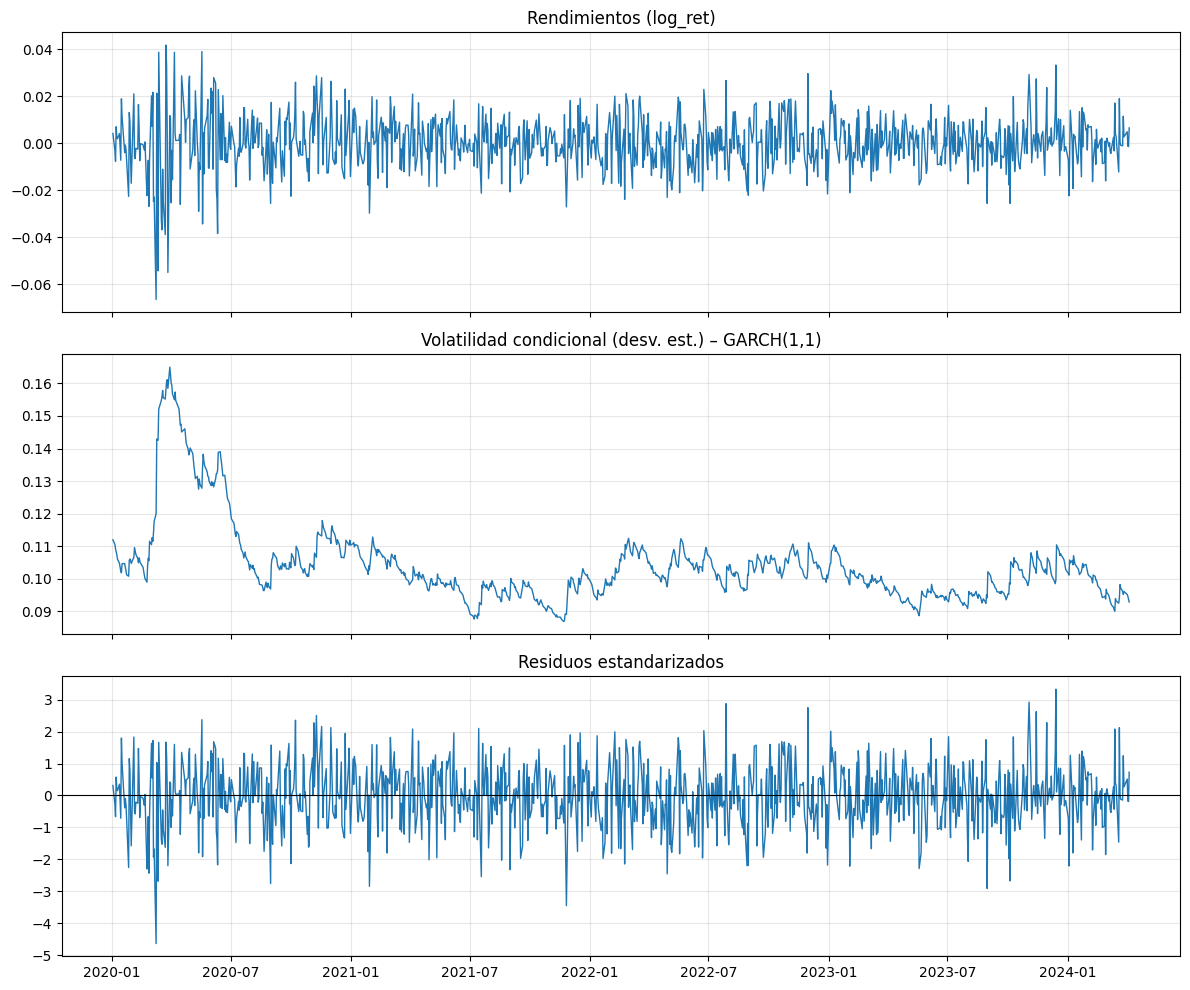

In [19]:
alpha = res.params.get('alpha[1]', np.nan)
beta  = res.params.get('beta[1]',  np.nan)
omega = res.params.get('omega',    np.nan)
print(f"Omega: {omega:.6f} | Alpha: {alpha:.6f} | Beta: {beta:.6f} | Alpha+Beta: {(alpha+beta):.6f}")

std_resid = res.std_resid
hist_vol = np.sqrt(res.conditional_volatility.values)
dates_hist = df['date'].iloc[-len(hist_vol):].values

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df['date'].iloc[-len(y):], y, lw=1)
axes[0].set_title('Rendimientos (log_ret)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['date'].iloc[-len(y):], np.sqrt(res.conditional_volatility), lw=1)
axes[1].set_title('Volatilidad condicional (desv. est.) – GARCH(1,1)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['date'].iloc[-len(y):], std_resid, lw=1)
axes[2].axhline(0, color='black', lw=0.8)
axes[2].set_title('Residuos estandarizados')
axes[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

- En esta parte utilizo el modelo GARCH ya ajustado para pronosticar la volatilidad futura ( 10 días hábiles en este primera prueba ). Esto no significa que predigo los rendimientos exactos del IPC, sino que anticipo cuánta variabilidad puedo esperar en el futuro cercano.
- no la serie histórica con la volatilidad pronosticada para visualizar cómo podrían evolucionar los “niveles de incertidumbre” en los próximos días.

Varianza pronosticada: [0.00012571 0.00012354 0.00012203 0.00012096 0.00012022 0.0001197
 0.00011934 0.00011908 0.0001189  0.00011878]
Volatilidad (desv. est.) pronosticada: [0.01121202 0.01111498 0.01104655 0.01099839 0.01096455 0.01094079
 0.01092414 0.01091246 0.01090428 0.01089855]


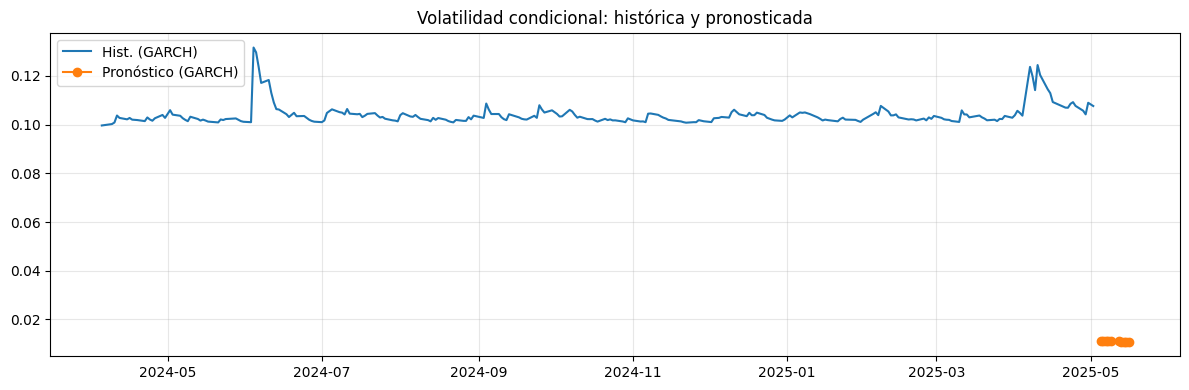

In [6]:
h = 10  # horizonte de días hábiles
fc = res.forecast(horizon=h, reindex=False)

var_fore = fc.variance.values[-1]
vol_fore = np.sqrt(var_fore)

print("Varianza pronosticada:", var_fore)
print("Volatilidad (desv. est.) pronosticada:", vol_fore)

future_dates = pd.bdate_range(df['date'].iloc[-1] + pd.Timedelta(days=1), periods=h)

plt.figure(figsize=(12,4))
plt.plot(dates_hist, hist_vol, label='Hist. (GARCH)')
plt.plot(future_dates, vol_fore, marker='o', label='Pronóstico (GARCH)')
plt.title('Volatilidad condicional: histórica y pronosticada')
plt.grid(True, alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()

- aplico el mismo modelo GARCH(1,1) a todas las columnas numéricas del dataset.
para comparar la persistencia y significancia de la volatilidad entre diferentes variables.

In [20]:
from arch import arch_model

tratar_como_nivel_y_convertir = []  #['open_price', 'close_price', 'vix_nivel']

def preparar_serie(s, convertir=False):
    s = pd.to_numeric(s, errors='coerce').dropna()
    if convertir:
        s = np.log(s).diff().dropna()
    return s - s.mean()

resultados, fallos = [], []

for col in num_cols:
    try:
        if col == 'log_ret':
            continue

        convertir = col in tratar_como_nivel_y_convertir
        y_col = preparar_serie(df[col], convertir=convertir)

        if len(y_col) < 100:
            raise ValueError("Muy pocos datos tras preparación.")

        am_col = arch_model(y_col, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
        res_col = am_col.fit(disp='off')

        alpha = res_col.params.get('alpha[1]', np.nan)
        beta  = res_col.params.get('beta[1]',  np.nan)
        omega = res_col.params.get('omega',    np.nan)

        resultados.append({
            'columna': col,
            'convertido_a_ret': convertir,
            'omega': omega,
            'alpha': alpha,
            'beta': beta,
            'alpha+beta (persistencia)': (alpha + beta) if np.isfinite(alpha) and np.isfinite(beta) else np.nan,
            'p(omega)': res_col.pvalues.get('omega', np.nan),
            'p(alpha)': res_col.pvalues.get('alpha[1]', np.nan),
            'p(beta)':  res_col.pvalues.get('beta[1]',  np.nan),
            'n_obs': int(len(y_col))
        })

    except Exception as e:
        fallos.append((col, str(e)))

tbl = pd.DataFrame(resultados).sort_values('alpha+beta (persistencia)', ascending=False).reset_index(drop=True)
print("Resumen GARCH por columna numérica:")
display(tbl)

if fallos:
    print("\nColumnas con error (revisa si requieren conversión a rendimientos):")
    for c, msg in fallos:
        print(f"- {c}: {msg}")


Resumen GARCH por columna numérica:


,columna,convertido_a_ret,omega,alpha,beta,alpha+beta (persistencia),p(omega),p(alpha),p(beta),n_obs
0,cetes_28_d1,False,0.000696,0.024597,0.975403,1.000000,0.504605,5.708086e-18,0.000000e+00,1038
1,vix_d0,False,0.026570,0.878182,0.112712,0.990894,0.000177,3.094696e-38,7.207917e-02,1038
2,volume_d0,False,0.016037,0.000012,0.984655,0.984666,0.340488,9.975181e-01,0.000000e+00,1038
3,high_d0,False,0.022215,0.061162,0.915360,0.976522,0.041352,7.022222e-04,0.000000e+00,1038
4,open_d0,False,0.023346,0.053549,0.922335,0.975884,0.172498,1.602834e-02,3.756112e-144,1038
5,wti_oil_d0,False,0.025843,0.185081,0.787977,0.973057,0.004178,7.357764e-05,1.468998e-93,1038
6,sp500_d0,False,0.029328,0.159401,0.808321,0.967723,0.017820,9.086497e-05,8.807619e-67,1038
7,udis_d1,False,0.053835,0.058047,0.885605,0.943652,0.003413,1.559418e-04,0.000000e+00,1038


## **EGARCH**

- EGARCH permite capturar asimetrías en la volatilidad (ejem cuando las caídas tienen efectos distintos a las subidas).
También uso una distribución t-Student en lugar de la normal para los errores, (suele funcionar mejor en datos financieros que tienen colas más pesadas.)

In [8]:
am_eg = arch_model(y_centered, mean='Constant', vol='EGarch', p=1, q=1, dist='t')
res_eg = am_eg.fit(disp='off')
print(res_eg.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                831.164
Distribution:      Standardized Student's t   AIC:                          -1652.33
Method:                  Maximum Likelihood   BIC:                          -1634.51
                                              No. Observations:                  261
Date:                      Thu, Nov 06 2025   Df Residuals:                      260
Time:                              20:59:23   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


# **TT2 - Modelo GARCH - Datos Imputados**

In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/df_serie_numerica_complete.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df['pct_change'] = df['Close'].pct_change()
# Calculamos retornos logarítmicos
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

df = df.dropna()
df.head()

,Date,Close,sp500,wti_oil,vix,dollar_index,dolar_cambio,udis,tasa_ref,tiie_28,cetes_28,pct_change,log_ret
1,2019-12-31,43541.019531,3230.780029,61.060001,13.780000,96.389999,18.864200,6.399018,7.25,7.555000,9.953578,-2.667606e-03,-2.671170e-03
2,2020-01-01,36009.643246,3244.286830,61.119971,13.108646,96.619725,20.855524,6.400419,7.25,7.289631,9.950698,-1.729720e-01,-1.899167e-01
3,2020-01-02,44437.230469,3257.850098,61.180000,12.470000,96.849998,18.881700,6.401821,7.25,7.552500,9.943954,2.340370e-01,2.102909e-01
4,2020-01-03,44624.851562,3234.850098,63.049999,14.020000,96.839996,18.867300,6.403224,7.25,7.549500,9.945963,4.222160e-03,4.213272e-03
5,2020-01-04,44624.851562,3234.850098,63.049999,14.020000,96.839996,18.867300,6.403224,7.25,7.549500,9.945963,8.881784e-16,8.881784e-16


In [12]:
!pip -q install "numpy>=2.0" "scipy>=1.11" "pandas>=2.0" "arch>=7.0"

In [23]:
from arch import arch_model

y = df['log_ret']

modelo_garch = arch_model(y, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
resultado_garch = modelo_garch.fit(disp='off')

print(resultado_garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5793.44
Distribution:                  Normal   AIC:                          -11578.9
Method:            Maximum Likelihood   BIC:                          -11556.3
                                        No. Observations:                 2071
Date:                Thu, Nov 06 2025   Df Residuals:                     2070
Time:                        21:12:35   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.2920e-04  3.009e-04      0.429      0.668 

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [24]:
modelo_egarch = arch_model(y, mean='Constant', vol='EGarch', p=1, q=1, dist='t')
resultado_egarch = modelo_egarch.fit(disp='off')

print(resultado_egarch.summary())

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -13136.7
Distribution:      Standardized Student's t   AIC:                           26283.3
Method:                  Maximum Likelihood   BIC:                           26311.5
                                              No. Observations:                 2071
Date:                      Thu, Nov 06 2025   Df Residuals:                     2070
Time:                              21:12:38   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           -42

/tmp/ipython-input-462820165.py:2: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  resultado_egarch = modelo_egarch.fit(disp='off')


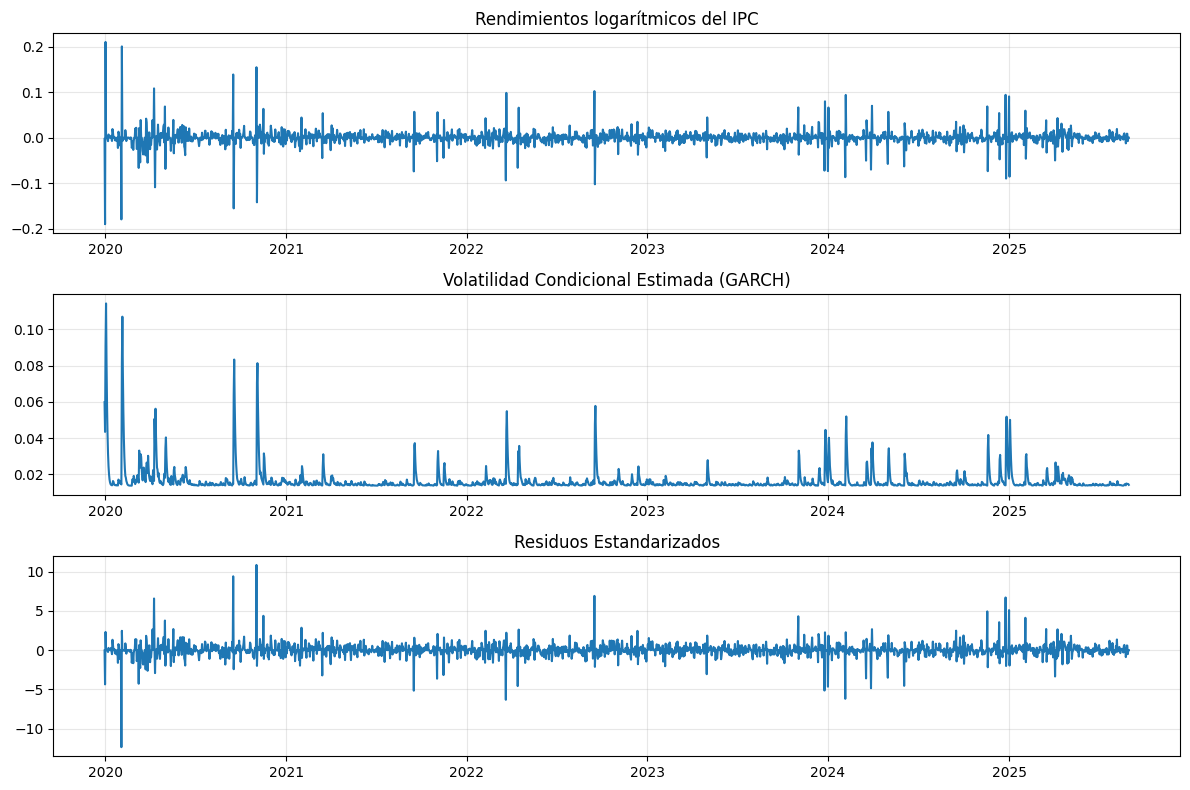

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(df['Date'], y)
plt.title('Rendimientos logarítmicos del IPC')
plt.grid(True, alpha=0.3)

plt.subplot(3,1,2)
plt.plot(df['Date'], resultado_garch.conditional_volatility)
plt.title('Volatilidad Condicional Estimada (GARCH)')
plt.grid(True, alpha=0.3)

plt.subplot(3,1,3)
plt.plot(df['Date'], resultado_garch.std_resid)
plt.title('Residuos Estandarizados')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
h = 10  # días
fc = resultado_garch.forecast(horizon=h, reindex=False)
vol_pronosticada = np.sqrt(fc.variance.values[-1])
print(vol_pronosticada)

[0.01405307 0.01528945 0.01609852 0.01664148 0.01701125 0.01726537
 0.01744105 0.01756299 0.01764784 0.01770699]


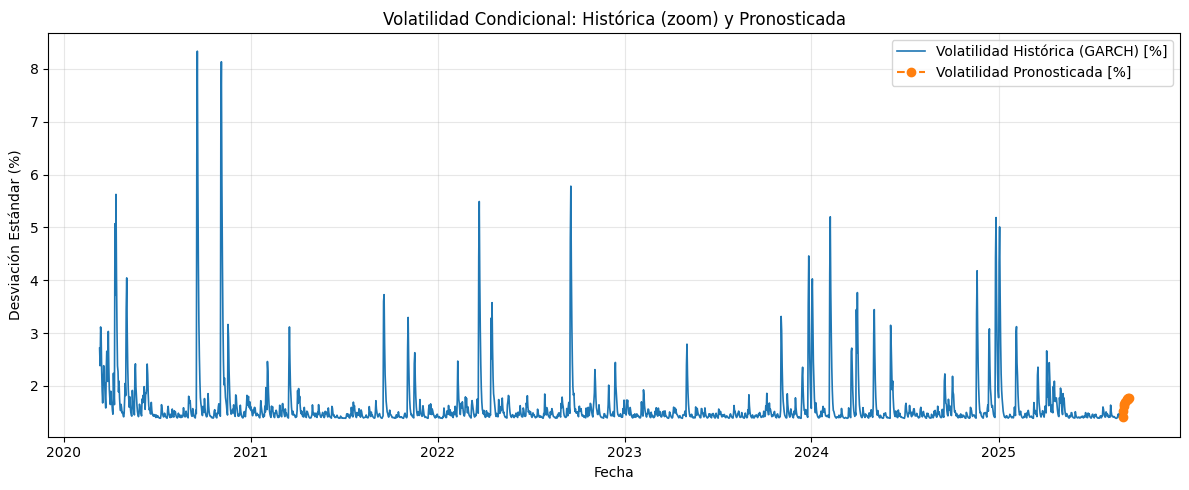

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

h = 10
fc = resultado_garch.forecast(horizon=h, reindex=False)
vol_fore = np.sqrt(fc.variance.values[-1])
dates_fore = pd.bdate_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=h)

vol_hist = np.asarray(resultado_garch.conditional_volatility)
dates_hist = df['Date'].iloc[-len(vol_hist):].values

vol_hist_pct = 100 * vol_hist
vol_fore_pct = 100 * vol_fore

window = 2000
vol_hist_pct_zoom = vol_hist_pct[-window:]
dates_hist_zoom = dates_hist[-window:]

plt.figure(figsize=(12,5))
plt.plot(dates_hist_zoom, vol_hist_pct_zoom, label="Volatilidad Histórica (GARCH) [%]", linewidth=1.2)
plt.plot(dates_fore, vol_fore_pct, marker='o', linestyle='--', label="Volatilidad Pronosticada [%]")

plt.title("Volatilidad Condicional: Histórica (zoom) y Pronosticada")
plt.xlabel("Fecha"); plt.ylabel("Desviación Estándar (%)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()